In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
# Notebook内に画像を表示させるモジュール
from IPython.display import Image  
# 決定木モデルを可視化するためのモジュール
import pydotplus


from sklearn.model_selection import train_test_split

#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import optuna

C:\Users\imyme\anaconda3\envs\flask\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#データ取得
df_train = pd.read_csv("../main/data/train.csv")


In [3]:
#restingBPのカテゴリー作成
df_train['BP_Cat']=0
for i in range(len(df_train)):
    if 120 <= df_train.loc[i,'RestingBP']<130:
        df_train.loc[i,'BP_Cat']=1
    elif 130 <= df_train.loc[i,'RestingBP']<140:
        df_train.loc[i,'BP_Cat']=2
    elif df_train.loc[i,'RestingBP']>140:
        df_train.loc[i,'BP_Cat']=3

In [4]:
#Max_HRについて変換
df_train['MaxHR_2']=207-df_train['Age']*0.7-df_train['MaxHR']

In [5]:

#特徴量作成
df_train['H_risk']='HR0'
for i in range(len(df_train)):
    #修正:Downはリスク低い
    if -0.3<df_train.loc[i,'Oldpeak']<0.3 and df_train.loc[i,'ST_Slope']=='Flat':
        df_train.loc[i,'H_risk']='HR2'
    elif 0.3<=df_train.loc[i,'Oldpeak']<2.5 and df_train.loc[i,'ST_Slope']=='Up':
        df_train.loc[i,'H_risk']='HR1'
    elif 0.3<=abs(df_train.loc[i,'Oldpeak'])<2.5 and df_train.loc[i,'ST_Slope']!='Up':
        df_train.loc[i,'H_risk']='HR3'
    elif df_train.loc[i,'Oldpeak']>=2.5 or df_train.loc[i,'Oldpeak']<=-0.3:
        df_train.loc[i,'H_risk']='HR4'
    else:
        pass

df_train['CholCat']='chol0'
for i in range(len(df_train)):
    if 200>df_train.loc[i,'Cholesterol']>0:
        df_train.loc[i,'CholCat']='chol1'
    if 240>df_train.loc[i,'Cholesterol']>=200:
        df_train.loc[i,'CholCat']='chol2'
    elif 280>df_train.loc[i,'Cholesterol']>=240:
        df_train.loc[i,'CholCat']='chol3'
    elif df_train.loc[i,'Cholesterol']>=280:
        df_train.loc[i,'CholCat']='chol4'
    else:
        pass

    
#TAとNAPをTA+NAPとする(分布が似ているかつカテゴリー中のデータ数が少ないため)
df_train.loc[df_train['ChestPainType']=='TA','ChestPainType']='TA+ATA'
df_train.loc[df_train['ChestPainType']=='ATA','ChestPainType']='TA+ATA'
df_train['ChestPainType'].unique()


#OneHotencoder

#ラベルエンコーダーでエンコーディング
CPT_mapping = {'ASY':2, 'TA+ATA':1, 'NAP':0}
df_train['cpt_l'] = df_train['ChestPainType'].map(CPT_mapping)

RECG_mapping = {'ST':1, 'LVH':2, 'Normal':0}
df_train['recg_l'] = df_train['RestingECG'].map(RECG_mapping)

Hrisk_mapping = {'HR0':0, 'HR1':1, 'HR2':2,'HR3':3,'HR4':4}
df_train['H_risk_l'] = df_train['H_risk'].map(Hrisk_mapping)

Chol_mapping = {'chol0':4, 'chol1':0, 'chol2':1,'chol3':2}
df_train['chol_l'] = df_train['CholCat'].map(Chol_mapping)

Slop_mapping = {'Up':0, 'Flat':2, 'Down':1}
df_train['slop_l'] = df_train['ST_Slope'].map(Slop_mapping)

#ChestPainType,RestingECG,ST_SlopをOneHotEncoding
#df_train=df_train.join(pd.get_dummies(df_train['ChestPainType']))
#df_train=df_train.join(pd.get_dummies(df_train['RestingECG']))
#df_train=df_train.join(pd.get_dummies(df_train['CholCat']))
#df_train=df_train.join(pd.get_dummies(df_train['H_risk']))
#df_train=df_train.join(pd.get_dummies(df_train['ST_Slope']))

#cholesterol値以外の数値データを標準化

#データ標準化する対象を選択
numeric_features=['Age','RestingBP', 'MaxHR','Cholesterol','Oldpeak']

#標準化したデータを元のデータに入れる
#_zで標準化したデータに対応
#SS=StandardScaler()
#df_train[['Age_z','RestingBP_z','MaxHR_z','Cholesterol_z','Oldpeak_z']]=SS.fit_transform(df_train[numeric_features].values)




In [9]:
target = "HeartDisease"
features2 = ['Age','Sex','RestingBP','Cholesterol','FastingBS','MaxHR', 'ExerciseAngina','Oldpeak','LVH','Normal','ST', 'Down', 'Flat', 'Up']
features_a4 = ['Age','Sex','RestingBP','FastingBS','MaxHR', 'ExerciseAngina','LVH','Cholesterol','Up','Flat','Down','Oldpeak']
features_a4 = ['Age','Sex','RestingBP','FastingBS','MaxHR', 'ExerciseAngina','LVH','Cholesterol','Up','Flat','Down','Oldpeak','ST','ASY','TA+ATA','NAP']

features_d1 = ['Age','Sex','BP_Cat','FastingBS','MaxHR', 'ExerciseAngina','LVH','Cholesterol','Up','Flat','Down','Oldpeak','ASY']

features_d2 = ['Age','Sex','BP_Cat','FastingBS','MaxHR', 'ExerciseAngina','LVH','Cholesterol','Up','Flat','Down','Oldpeak']

features_d3 = ['Age','Sex','RestingBP','FastingBS','MaxHR', 'ExerciseAngina','Cholesterol','Oldpeak','cpt_l','recg_l','slop_l']
features_d4 = ['Age','Sex','RestingBP','FastingBS','MaxHR_2', 'ExerciseAngina','Cholesterol','Oldpeak','cpt_l','recg_l','slop_l']

In [1]:
#モデル作成
#params= {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.048, 'ccp_alpha': 0.040}
params={'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4,'class_weight':'balanced','random_state':82}
DC = DecisionTreeClassifier(**params)

#特徴量選択
features=features_d4

#5分割公差検証
#変数
X_DC = df_train[features]
Y = df_train[target]

#交差検証
score_DC = cross_val_score(DC, X_DC, Y, cv=5)  

#正解率を出力する
print(f"スコア LC 交差バージョン: {score_DC}")
print("")

#平均値を出力する
print(f"平均値 LC 交差バージョン： {score_DC.mean()}")
print("")

NameError: name 'DecisionTreeClassifier' is not defined

In [94]:
?DecisionTreeClassifier

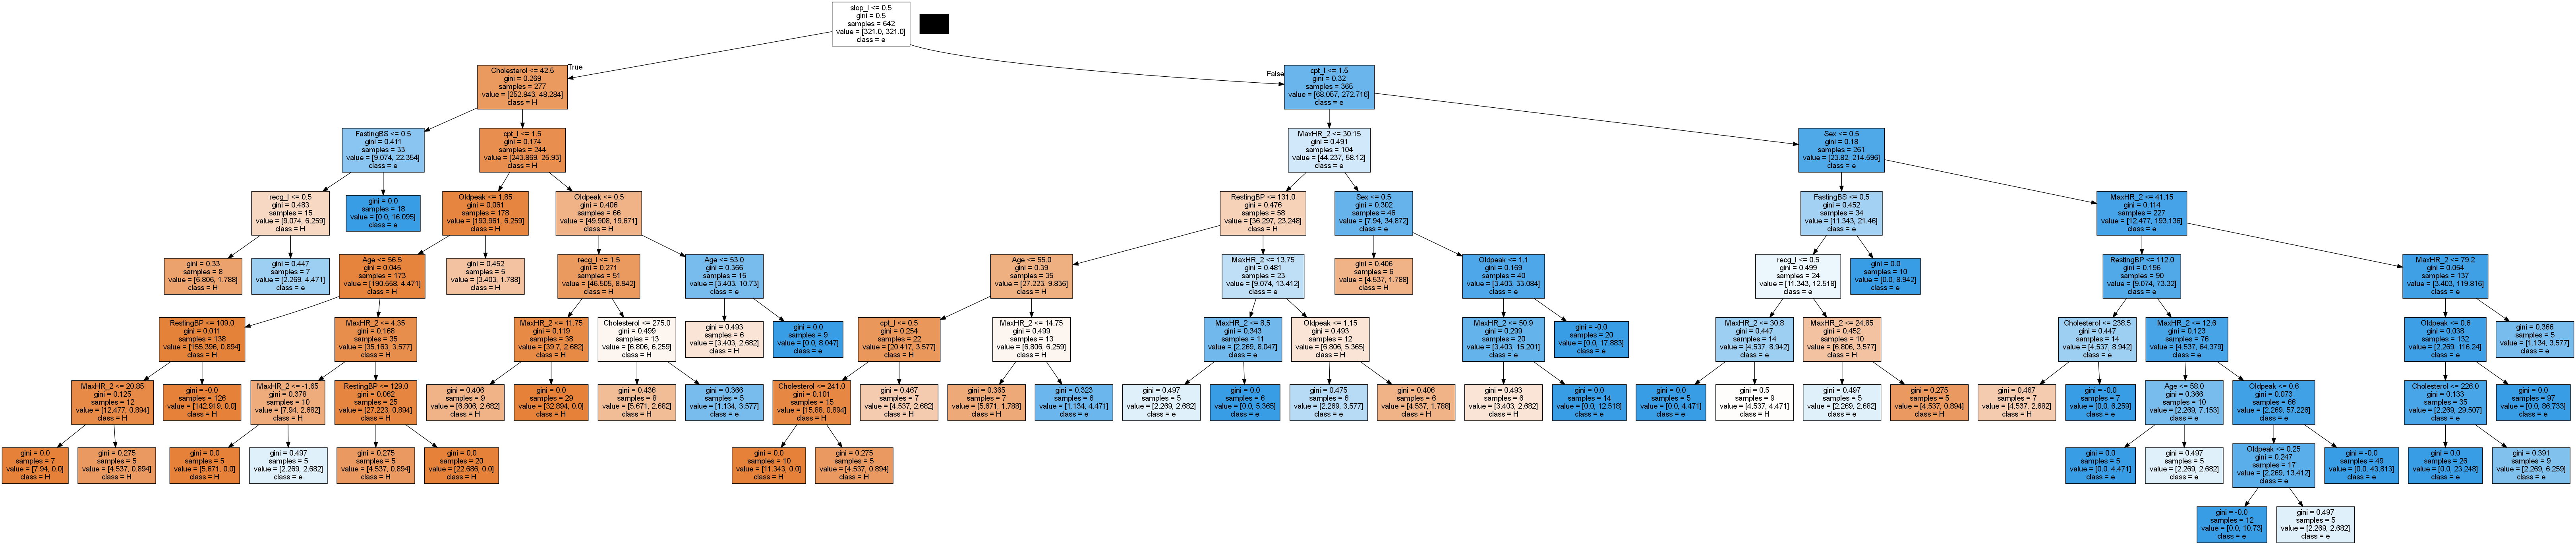

In [8]:
#それぞれの特徴量の係数
DC.fit(X_DC,Y)

# 決定木モデルをDOTデータに変換
dot_data = export_graphviz(DC,                              # 決定木モデルを指定
                                out_file = None,                    # 出力ファイルではなく文字列を返すように指定
                                feature_names = features, # 特徴量の表示名を指定
                                class_names = target,    # クラス分類の表示名を指定
                                filled = True)                      # 多数派クラスでノードを色付け

# ダイアグラムを描画
graph = pydotplus.graph_from_dot_data(dot_data)  

# ダイアグラムを表示
Image(graph.create_png())

In [16]:
#結果を入れるためのDataFrame
df_coef=pd.DataFrame()

for i in range(len(features)):
    #print(features[i],':',LR.coef_[0,i])
    df_coef.loc[i,'features']=features[i]
    df_coef.loc[i,'coef']=DC.feature_importances_[i]

#降順に並べる
df_coef=df_coef.sort_values('coef',ascending=False)

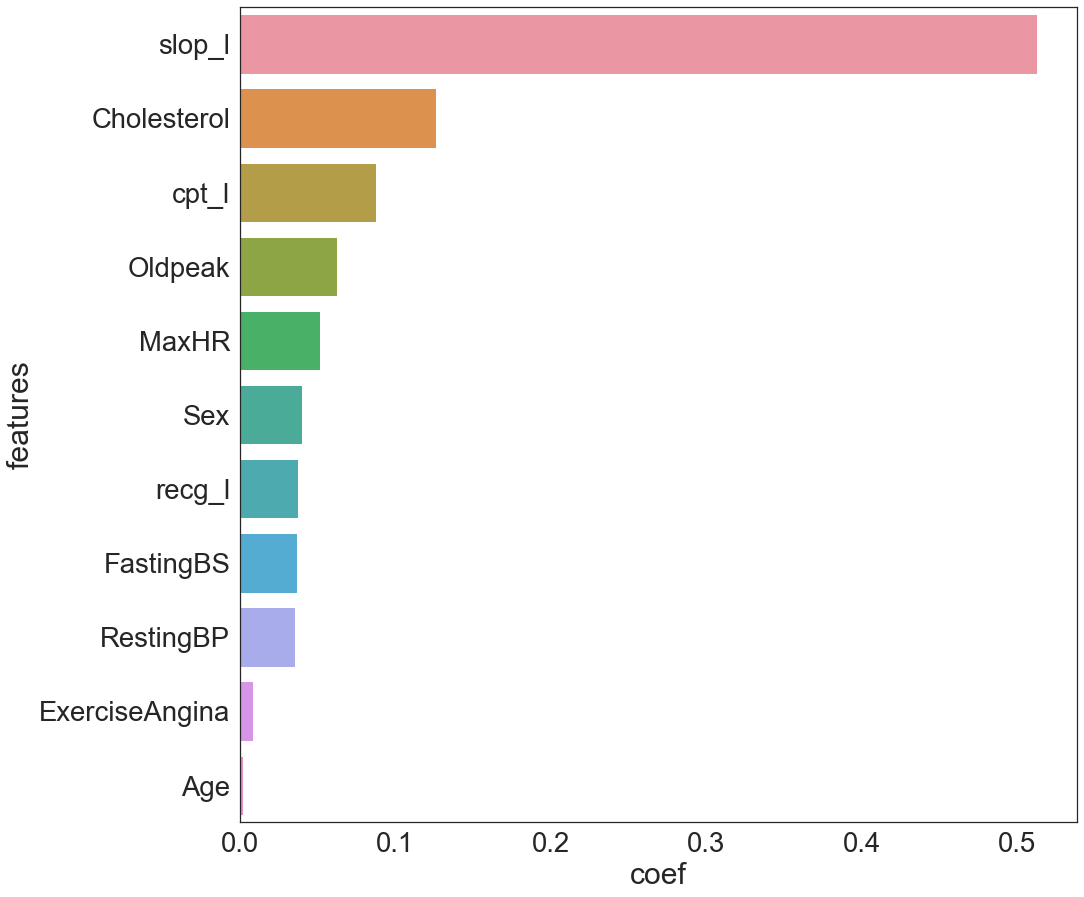

In [17]:
plt.figure(figsize=(15,15))
sns.set(font_scale=2.5,style='white',palette='bright')
sns.barplot(df_coef,x='coef',y='features')
plt.show()

In [12]:
#データ取得用公差検証

#Kfoldでtrainとtestのindexを取得
kf = KFold(n_splits=5,shuffle=True,random_state=46)

#df_trainの行を準備
df_train[['DC_prob','DC_pred']]=0

val_pred=[]
val_lists=[]
val_pred_acc=[]

#foldした分だけpredictを回す(公差検証)
for i,(train_index,val_index) in enumerate(kf.split(df_train)):
    
    #validationのindexを取得
    val_lists.append(val_index)
    
    #それぞれのモデルのfit
    DC.fit(X_DC.loc[train_index,:],Y[train_index])

    #それぞれのモデルでtestをpredict_prabaして確率を保存
    DC_proba=DC.predict_proba(X_DC.loc[val_index,:])
    
    #df_trainに心臓病確率を入れる
    df_train.loc[val_index,'DC_prob']=DC_proba[:,1]

    #df_trainに心臓病予測を入れる
    df_train.loc[val_index,'DC_pred']=DC.predict(X_DC.loc[val_index,:])
    
    #正答率をリストに入れる
    val_pred_acc.append(accuracy_score(df_train.loc[val_index,'HeartDisease'].values,df_train.loc[val_index,'DC_pred'].values))
    

    
#公差検証の結果
print('5分割:',val_pred_acc)
print('5分割平均:',sum(val_pred_acc)/len(val_pred_acc))

#データ全体の正答率
print('全体:',accuracy_score(df_train['HeartDisease'].values,df_train['DC_pred'].values))

5分割: [0.8527131782945736, 0.8449612403100775, 0.8203125, 0.8671875, 0.828125]
5分割平均: 0.8426598837209301
全体: 0.8426791277258567


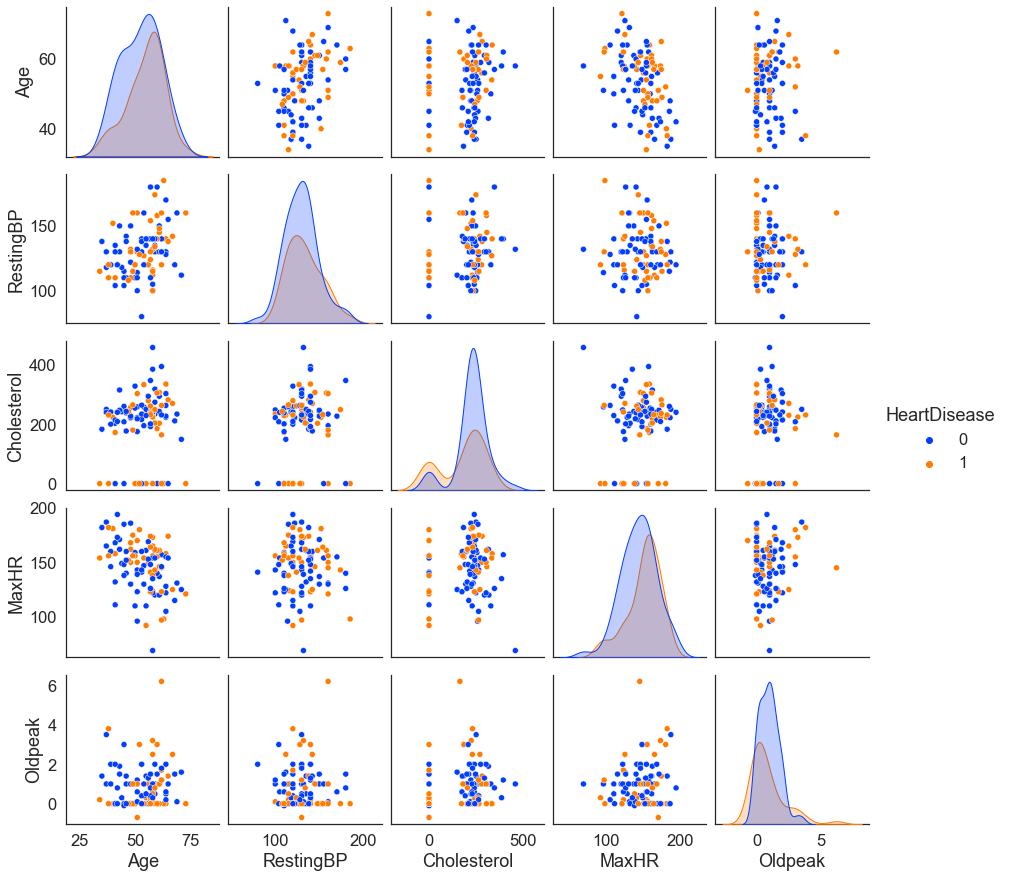

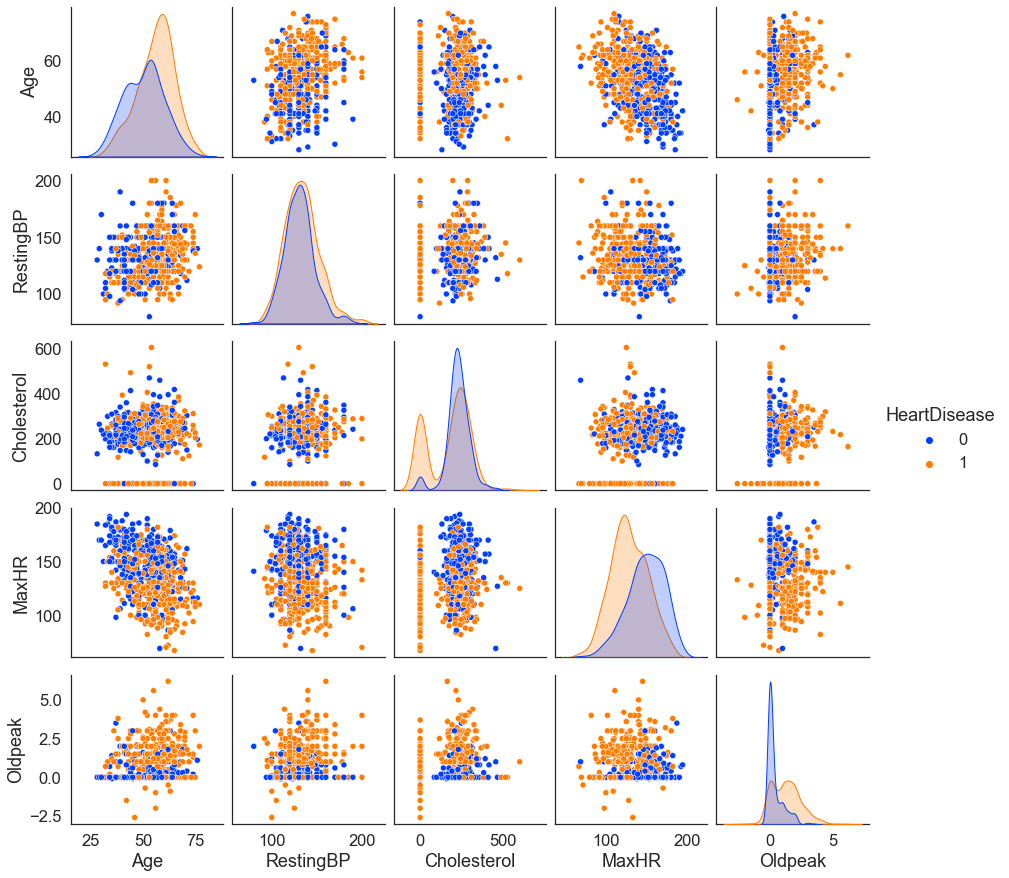

In [13]:
#正解の場合"1"になる列を作成

#seabornのグラフ設定
sns.set(font_scale=1.5,style='white',palette='bright')

df_train['ACC_DC']=0
for i in range(len(df_train)):
    if df_train.loc[i,'HeartDisease']==df_train.loc[i,'DC_pred']:
        df_train.loc[i,'ACC_DC']=1
    else:
        pass


#間違いだけのデータフレーム作成
df_train_wrong=df_train.copy()
df_train_wrong=df_train_wrong.query('ACC_DC==0')

#pairplotの作成,心臓病のありなしで色分け
sns.pairplot(df_train_wrong,vars=['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'],hue='HeartDisease')

#図を保存する場合に実行
#plt.savefig('./WrongAnswers/LR_dummy1.png')

#比較用に、元データのpairplotも表示
sns.pairplot(df_train,vars=['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'],hue='HeartDisease')
plt.show()

In [15]:
#予測と正解のクロス集計表
pd.crosstab(df_train['HeartDisease'],df_train['DC_pred'])

DC_pred,0,1
HeartDisease,,
0,223,60
1,41,318


In [11]:
## Optuna


#クラス作成
class Objective():
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ハイパーパラメータの設定
        params = {
            # 損失関数
            'criterion' : trial.suggest_categorical('criterion',['gini','entropy']),
            # 深さ
            'max_depth': trial.suggest_categorical('max_depth', [5,6,7,8,9,10,11,12,13,14]),
            #min_sample_split
            'min_samples_split':trial.suggest_int('min_samples_split',2,10),
            #min_samples_leaf
             'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,8),
            #min_weight_fraction_leaf
            #'min_weight_fraction_leaf':trial.suggest_float('min_weight_fraction_leaf',0,0.5),
            #min_impurity_decrease
            #'min_impurity_decrease':trial.suggest_float('min_impurity_decrease',0,3),
            #class_weight
            'class_weight':None,#trial.suggest_categorical('class_weight',['balanced','None']),
            # 正則化の種類(elastic netは別枠でやる)
            #'ccp_alpha':trial.suggest_float('ccp_alpha',0,2)
            }

        model = DecisionTreeClassifier(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, 
                                y=self.y,
                                scoring='accuracy', # 正解率を指定（https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter）
                                n_jobs=-1) # 並行して実行するジョブの数（-1は全てのプロセッサを使用）
        return scores['test_score'].mean()


    
    
    

In [12]:
objective = Objective(X_DC, Y)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize') # 最大化
study.optimize(objective,n_trials=400)

# ベストパラメータを出力
print('params:', study.best_params)
print('score:', study.best_value)

params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 7}
score: 0.8379966085271316


params: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0478921883285937, 'ccp_alpha': 0.040274230754074825}
score: 0.8442708333333334

params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 7}
score: 0.8551235465116278

params: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.030112150823185833, 'min_impurity_decrease': 0.005186583469822231, 'ccp_alpha': 0.05593842319823157}
score: 0.8380692829457365